<a href="https://colab.research.google.com/github/pachterlab/GP_2021/blob/master/gg210207_gou_gill_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dependencies. Install GNU Octave and the ``oct2py`` interface.


In [1]:
import time  as ti
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import sys

tstart = ti.time()

import scipy 
import scipy.io as sio
import scipy.integrate
from scipy.special import gammaln

from scipy.stats import poisson, nbinom, gamma


%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!sudo apt-get install octave
# !sudo apt-get update -y
!sudo apt-get install -y liboctave-dev

In [3]:
%%capture
pip install oct2py

Pull the MATLAB code from Github.

In [4]:
%%capture
import oct2py
from oct2py import octave
oc = oct2py.Oct2Py()
oc.eval('pkg install -forge specfun')
oc.addpath('.')
oc.eval('pkg load specfun')
!wget -O gg_210207_gillespie_gou_oct_1.m https://raw.githubusercontent.com/pachterlab/GP_2021/master/gg_210207_gillespie_gou_oct_1.m

Define plotting aesthetics.

In [5]:
w_mean = 2
w_one = 0.5
w_comp = 1.5
col_mean = [0,0,0]
col_one = [0.5]*3
col_hist = [0.7]*3
scatter_col = [0.2]*3
scatter_size = 0.1
scatter_alpha = 0.3
col_theory = [1,0,0]
w_theory = 1.5
fontsize = 12
fontsize_big=16

Define the simulation driver to take in parameters and output a file with the statistics of interest.

In [6]:
def Gillespie_GOU_2D_data(beta,gamma,kappa,alpha,eta,T,lag,nCell,filename,T_=5,nT1=500,nT2=100):
    
    L = alpha*kappa
    splic = beta
    S = np.asarray(([[1, 0], [-1, 1], [0, -1], [0, 0]]))
    sde_params = np.array([kappa,L,eta])
    if T==None:
        Tscale = 1/min([kappa,gamma,L,splic])
        T = T_*Tscale

    tvec_mol = np.linspace(0,T,nT1)
    te = T+lag
    tvec_sde = np.linspace(T,te,nT2)
    tvec = np.concatenate((tvec_mol[:-1],tvec_sde))
    t_matrix = np.matlib.repmat(tvec,nCells,1)

    kpar = np.array([np.nan,splic,gamma])

    SDE = np.array([kappa,L,eta])
    
    t1 = ti.time()
    Y = oc.gg_210207_gillespie_gou_oct_1(kpar,t_matrix,S,nCells,SDE)[:,:,:3]
    trun = ti.time()-t1
    X_s = np.squeeze(Y[:,(nT1-1):,:2])
    SDE_t = np.squeeze(Y[:100,:nT1,2])
    SDE_mean = np.squeeze(np.mean(Y[:,:nT1,2],0))
    SDE_ss = np.squeeze(Y[:,nT1,2])

    meta = ('alpha, eta: shape and rate parameters of gamma distribution\t' + 'beta, gamma: splicing and degradation rate\n' 
            + 'kappa: mean-reversion rate\t' + 'T: simulation timescale end. Tmax = T/min([kappa, gamma, alpha*kappa, eta])\n' 
            + 'nCell: Number of cells\t' + 'trun: Runtime (seconds)\n'
            + 'nT: number of time points\t' + 'Tmax: End time\t' + 'tvec_sde: Time vector of SDE\n' 
            + 'X_s: 2D array of molecule counts in each cell at Tmax (nCell, 2)\n'
            + 'SDE_t: 100 samples of simulated CIR process (100, nT)\t' + 'SDE_mean: mean of all CIR processes (not SDE_t)')
    # SDE_mean = np.mean(SDE, axis = 0)            
    mdict={'runtime': trun, 'Ncell': nCell, 'Tmax': te, 'T': T, 'tvec_mol': tvec_mol, 'tvec_sde': tvec_sde,
            'X_s': np.array(X_s), 'SDE_t': SDE_t, 'SDE_mean': SDE_mean,
            'alpha': alpha, 'eta': eta, 'kappa': kappa, 'splic': splic, 'gamma': gamma, 'SDE_ss': SDE_ss,
            'metadata': meta}
    sio.savemat(filename, mdict, do_compression = True)


Define parameters in the intrinsic, extrinsic, and constitutive limits, as given in [the simulation preprint](https://www.biorxiv.org/content/10.1101/2021.01.20.427480v1). Run the simulations and store results in ``.mat`` files.

In [7]:
%%capture
splic = 1.2
gamma = 0.7 
kappa = [10,0.12,8.3e-4]
L = [0.1,0.01,0.1]
eta = [6.7e-3,6.7e-2,20]
nCells = 10000
T=None
lag=[0.01,0.01,0.01]
T_ = [5,5,0.1]
t1 = ti.time()
for i in range(3):
    Gillespie_GOU_2D_data(splic,gamma,kappa[i],L[i]/kappa[i],eta[i],T,lag[i],nCells,'gou_{:.0f}.mat'.format(i),T_ = T_[i],nT1=2,nT2=2)
runtime = ti.time()-t1

In [8]:
print('{:.0f} seconds elapsed.'.format(runtime))

141 seconds elapsed.


Define the functions that generate the analytical results in limiting regimes.

In [9]:
def compute_joint(which,L,eta,splic,gamma,kappa,a,b):
    if which==0:
        return np.squeeze(cme_integrator([L,1/(kappa*eta),gamma,splic],[a,b]))
    if which==1:
        return MVNB(L/kappa,eta,splic,gamma,a,b).T
    if which==2:
        mu = L/kappa/eta;
        return np.outer(poisson.pmf(np.arange(a),mu/splic),poisson.pmf(np.arange(b),mu/gamma))

The limiting results are given in [the noise disambiguation preprint](https://www.biorxiv.org/content/10.1101/2020.09.25.312868v1). The intrinsic noise results are due to [Singh & Bokes](https://linkinghub.elsevier.com/retrieve/pii/S0006349512007904). The extrinsic and constitutive noise results are standard from [Jahnke & Huisinga](https://link.springer.com/article/10.1007/s00285-006-0034-x).

In [10]:
def cme_integrator(phys,lm):
    M,N=lm
    NN = N
    N = 1+int(np.ceil((NN-1)/2))
    l=np.arange(M)
    k=np.arange(N)
    u_ = np.exp(-2j*np.pi*l/M)-1
    v_ = np.exp(-2j*np.pi*k/NN)-1
    u,v=np.meshgrid(u_,v_)
    u=u.flatten()
    v=v.flatten()
    fun = lambda x: INTFUNC_(x,phys[1:],u,v)    
    I = np.exp(scipy.integrate.quad_vec(fun,0,np.inf)[0]*phys[0])
    I = np.reshape(I.T,(N,M))
    N_fin = N+1 if np.mod(NN-1,2)==0 else -1
    I=np.vstack((I,np.hstack((np.reshape(
        np.flipud(I[1:N_fin,0].conj()),(N_fin-2,1)),np.flip(I[1:N_fin,1:].conj(),(0,1))))))
    return np.real(np.fft.ifft2(I)).T

    
def INTFUNC_(x,params,U,V):
    f = params[2]/(params[2]-params[1])
    Ufun = f*V*np.exp(-params[1]*x) + (U-V*f)*np.exp(-params[2]*x)
    filt = ~np.isfinite(f)
    if np.any(filt): #params[1] = params[2]
    	Ufun[filt] = np.exp(-params[1]*x)*(U[filt] + params[1]*V[filt]*x)
    Ufun = params[0]*Ufun
    return Ufun/(1-Ufun)

def MVNB(a,eta,b,g,n,m):
    N,M = np.meshgrid(np.arange(n),np.arange(m))
    C = 1+(1/b+1/g)/eta
    Z_ = gammaln(a+N+M) - gammaln(a) - gammaln(N+1) - gammaln(M+1) - a*np.log(C) - N*np.log(C*eta*b) - M*np.log(C*eta*g)
    return np.exp(Z_)


Plot the results for the transcription signal and the molecular counts, and compare to theory!


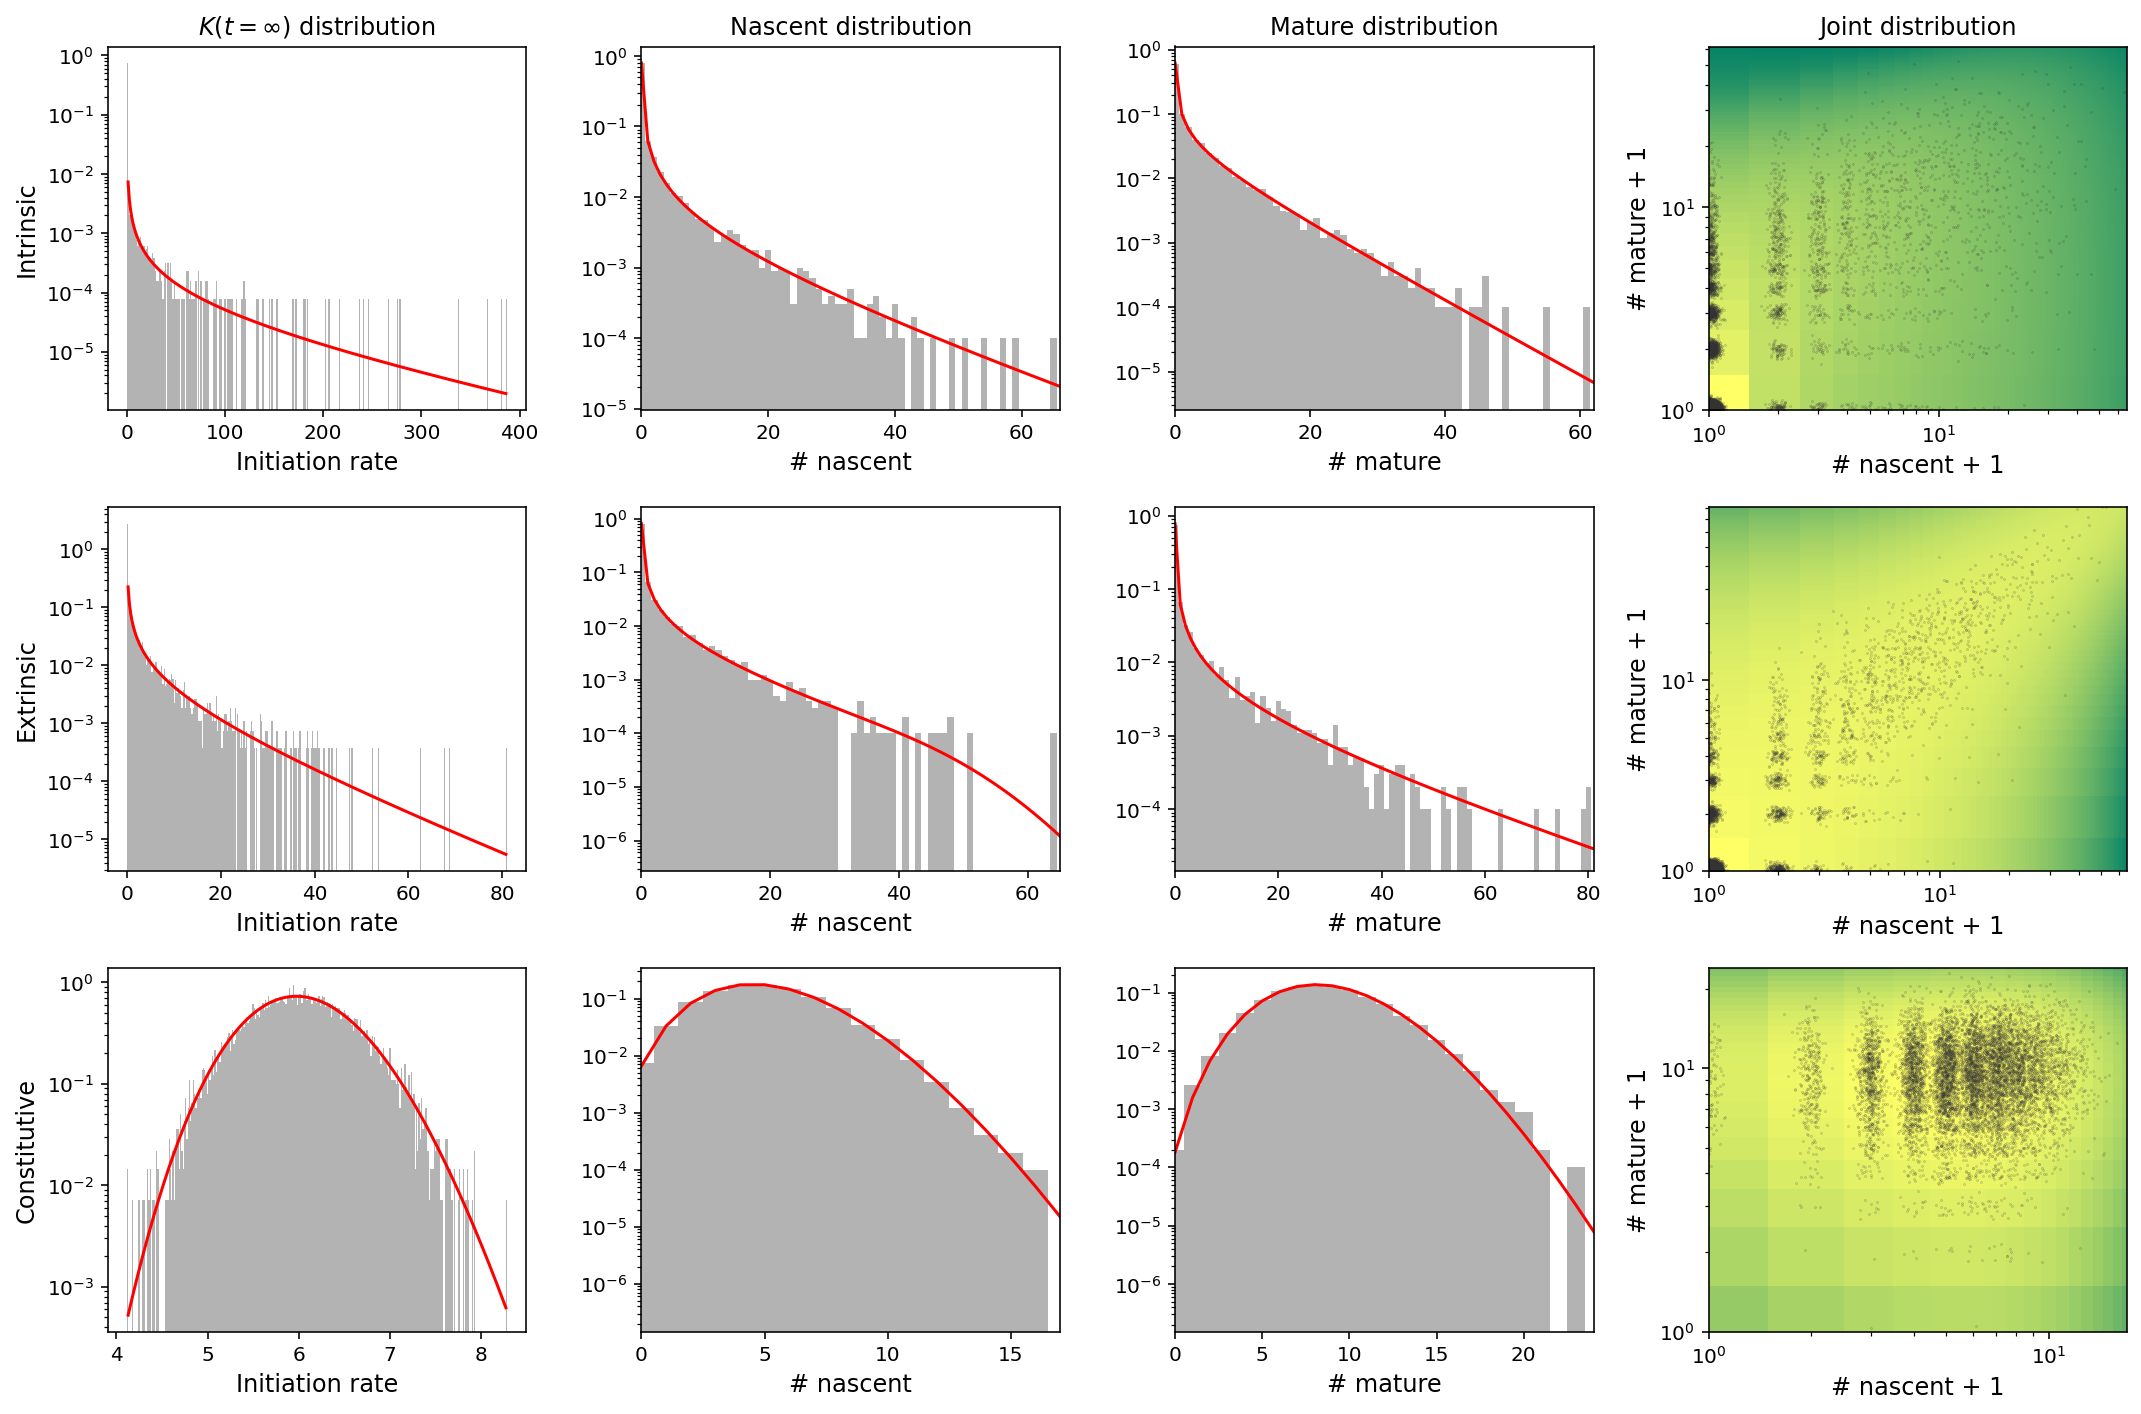

In [11]:
syslabel = ('Intrinsic','Extrinsic','Constitutive')
xlabel = ('Initiation rate','# nascent','# mature')
jlabel = ('# nascent + 1','# mature + 1')
titles = (r'$K(t=\infty)$ distribution','Nascent distribution','Mature distribution','Joint distribution')

sz = (3,4)
figsize = (15,10)
fig1,ax1=plt.subplots(nrows=sz[0],ncols=sz[1],figsize=figsize)

splic_name = 'splic'

for k_ in range(3):
    F = sio.loadmat('gou_{:.0f}'.format(k_))
    kappa = F['kappa'][0,0]
    alpha = F['alpha'][0][0]
    L = alpha*kappa
    eta = F['eta'][0,0]
    splic = F[splic_name][0][0]
    gamma = F['gamma'][0][0]


    X_s = F['X_s'][:,0,:]
    SDE_ss = F['SDE_ss'][0]
    tvec = F['tvec_sde'][0]
    T_ss = np.inf
    offs = 5

    x_nas = np.arange(np.amax(X_s[:,0])+offs)
    x_mat = np.arange(np.amax(X_s[:,1])+offs)

    Pss = np.squeeze(compute_joint(k_,L,eta,splic,gamma,kappa,int(x_nas[-1]+1),int(x_mat[-1]+1)))

    ###TRANSCRIPTION RATE
    ax1[k_,0].hist(SDE_ss,bins=300, density=True,color=col_hist)
    x = np.linspace(min(SDE_ss),max(SDE_ss),300)[1:-1]
    y = scipy.stats.gamma.pdf(x,a=alpha,scale=1/eta)
    ax1[k_,0].plot(x,y,'-',linewidth=w_theory,color=col_theory)
    ax1[k_,0].set_yscale('log')

    ###NASCENT
    bins_ = x_nas-0.5
    ax1[k_,1].hist(X_s[:,0],bins=bins_, density=True,color=col_hist)

    y = np.sum(Pss,1)
    y = np.squeeze(y)[0:len(x_nas)]
    ax1[k_,1].plot(x_nas,y,'-',linewidth=w_theory,color=col_theory)
    ax1[k_,1].set_yscale('log')
    ax1[k_,1].set_xlim([0,np.amax(X_s[:,0])+1])
    
    ###MATURE
    bins_ = x_mat-0.5
    ax1[k_,2].hist(X_s[:,1],bins=bins_, density=True,color=col_hist)

    y = np.sum(Pss,0)
    y = np.squeeze(y)[0:len(x_mat)]
    ax1[k_,2].plot(x_mat,y,'-',linewidth=w_theory,color=col_theory)
    ax1[k_,2].set_yscale('log')
    ax1[k_,2].set_xlim([0,np.amax(X_s[:,1])+1])
    

    ###JOINT
    nCells = X_s.shape[0]
    noise = 1+np.random.randn(nCells,2)/20

    nas_ = (X_s[:,0]+1)*noise[:,0]
    filt = np.logical_and(X_s[:,0]==0, nas_<1)
    nas_[filt] = 2-nas_[filt]

    mat_ = (X_s[:,1]+1)*noise[:,1]
    filt = np.logical_and(X_s[:,1]==0, mat_<1)
    mat_[filt] = 2-mat_[filt]


    Pa = np.log10(np.squeeze(Pss)[0:len(x_nas),0:len(x_mat)])
    X_,Y_ = np.meshgrid(x_nas+0.5,x_mat+0.5)
    ax1[k_,3].pcolor(X_.T,Y_.T,Pa,cmap='summer')    
    ax1[k_,3].scatter(nas_,mat_,color=scatter_col,s=scatter_size,alpha=scatter_alpha,edgecolors=None)
    ax1[k_,3].set_xscale('log')
    ax1[k_,3].set_yscale('log')
    ax1[k_,3].set_xlim([1,np.amax(X_s[:,0])+1])
    ax1[k_,3].set_ylim([1,np.amax(X_s[:,1])+1])

    ax1[k_,0].set_ylabel(syslabel[k_],fontsize=fontsize)
    for j_ in range(3):
        ax1[k_,j_].set_xlabel(xlabel[j_],fontsize=fontsize)
    ax1[k_,3].set_xlabel(jlabel[0],fontsize=fontsize)
    ax1[k_,3].set_ylabel(jlabel[1],fontsize=fontsize)
    if k_==0:
        for j_ in range(4):
            ax1[k_,j_].set_title(titles[j_],fontsize=fontsize)
fig1.tight_layout()
plt.savefig('gou_fig3.png',dpi=450)


In [12]:
tend = ti.time()
print('{:.0f} seconds elapsed in total.'.format(tend-tstart))

232 seconds elapsed in total.
